# Data Scientist Salaries Linear Regression using PySpark

## Dependencies
Declare dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.preprocessing import LabelEncoder
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression



## Import Dataset

In [2]:
ds_df = pd.read_csv('ds_salaries.csv')
ds_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


### Label Encode non-numeric variables

In [3]:


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# List of categorical columns to encode
categorical_columns = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']

# Apply label encoding to each categorical column
for column in categorical_columns:
    ds_df[column] = label_encoder.fit_transform(ds_df[column])

# Display the first few rows of the updated dataframe
ds_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,3,2,84,80000,7,85847,26,100,25,0
1,2023,2,0,66,30000,19,30000,75,100,70,2
2,2023,2,0,66,25500,19,25500,75,100,70,2
3,2023,3,2,47,175000,19,175000,11,100,12,1
4,2023,3,2,47,120000,19,120000,11,100,12,1


### Initialize PySpark Session

In [4]:

# Initialize Spark session
spark = SparkSession.builder.appName("LinearRegressionDS").getOrCreate()
print("PySpark Version:", spark.version)



PySpark Version: 3.5.3


### Import DataFrame to a spark DataFrame

In [5]:
# Convert the pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(ds_df)

### Create column features as an array of features columns

In [6]:
# Assemble the features into a single vector
assembler = VectorAssembler(inputCols=['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'remote_ratio', 'company_location', 'company_size'], outputCol='features')
assembled_df = assembler.transform(spark_df)

assembled_df.show(5)

+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+--------------------+
|work_year|experience_level|employment_type|job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|            features|
+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+--------------------+
|     2023|               3|              2|       84| 80000|              7|        85847|                26|         100|              25|           0|[3.0,2.0,84.0,7.0...|
|     2023|               2|              0|       66| 30000|             19|        30000|                75|         100|              70|           2|[2.0,0.0,66.0,19....|
|     2023|               2|              0|       66| 25500|             19|        25500|                75|         100|  

Now we have a df with all our columns and a column "features" that is an array of them without salary_in_usd (Our target variable)

### Create a reduce DataFrame with only columns features and our target (salary_in_usd)

In [7]:
final_df = assembled_df.select('features', 'salary_in_usd')
final_df.show(5)

+--------------------+-------------+
|            features|salary_in_usd|
+--------------------+-------------+
|[3.0,2.0,84.0,7.0...|        85847|
|[2.0,0.0,66.0,19....|        30000|
|[2.0,0.0,66.0,19....|        25500|
|[3.0,2.0,47.0,19....|       175000|
|[3.0,2.0,47.0,19....|       120000|
+--------------------+-------------+
only showing top 5 rows



### Split data in train and test

In [8]:
# Split the data into training and test sets
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=3241)

## Model
### Create a LinearRegression model 
Using featurescol='features' and labelCol='salary_in_usd'

In [9]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='salary_in_usd')

### Fit the model with train data

In [10]:
# Fit the model on the training data
lr_model = lr.fit(train_data)

### Make predictions on test data

In [11]:
# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Show the predictions
predictions.select('features', 'salary_in_usd', 'prediction').show()

+--------------------+-------------+------------------+
|            features|salary_in_usd|        prediction|
+--------------------+-------------+------------------+
|[0.0,2.0,8.0,19.0...|       110680|105433.18978147353|
|[0.0,2.0,33.0,19....|        65000|108381.15568637686|
|[0.0,2.0,69.0,19....|       145885|126501.10447931405|
|[1.0,2.0,47.0,19....|       185000|130888.27938333123|
|[1.0,2.0,91.0,19....|        15000| 144419.1070693956|
|[2.0,0.0,66.0,19....|        25500|102509.80148189735|
|[2.0,2.0,25.0,8.0...|        42533| 65087.33825566176|
|[2.0,2.0,47.0,8.0...|        66837| 76160.64029579003|
|[2.0,2.0,69.0,7.0...|        96578|103767.59305613856|
|[3.0,2.0,8.0,19.0...|       222200|151814.62061390997|
|[3.0,2.0,8.0,19.0...|       222200|151814.62061390997|
|[3.0,2.0,18.0,19....|       225000|147212.60785508947|
|[3.0,2.0,23.0,19....|       342810|149729.26740966405|
|[3.0,2.0,25.0,19....|       104300|160371.26309946366|
|[3.0,2.0,25.0,19....|       138900|150735.93123

### Evaluate the model

In [12]:

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='salary_in_usd', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
r2 = lr_model.summary.r2

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")


Root Mean Squared Error (RMSE): 55009.29170252075
R2 Score: 0.2769770941712286


### Convert variables to plot them on a graph

In [13]:

predictions_plot = predictions.select('prediction').toPandas()
targets_plot = predictions.select('salary_in_usd').toPandas()



### Close Spark Session


In [14]:
spark.stop()

## Plot a Graph 
#### Comparing predictions and Actual Salary of our test_data

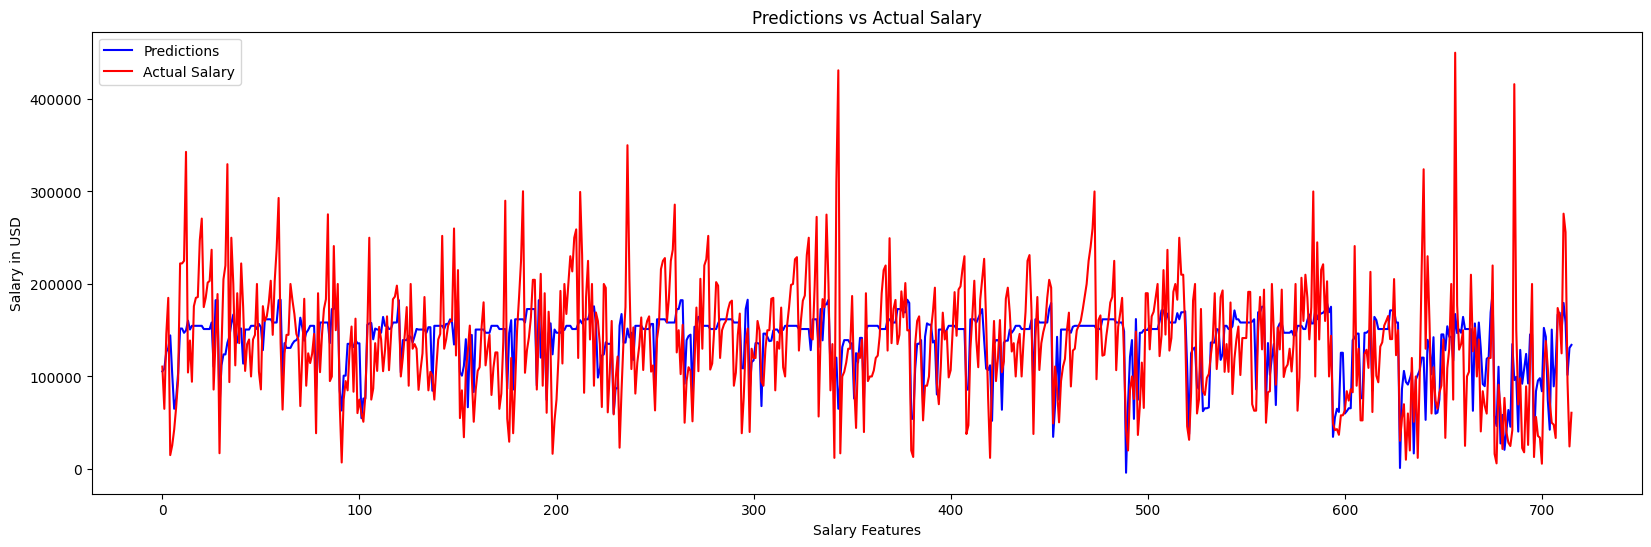

In [15]:
plt.figure(figsize=(20, 6))

# Plot the predictions
plt.plot(predictions_plot, label='Predictions', color='blue')

# Plot the actual targets
plt.plot(targets_plot, label='Actual Salary', color='red')

# Add title and labels
plt.title('Predictions vs Actual Salary')
plt.xlabel('Salary Features')
plt.ylabel('Salary in USD')

# Add legend
plt.legend()

# Show the plot
plt.show()

### Conclusion
Our model is not really predicting very well the salaries using Linear Regression, the R2 score is 0.27 so we can tell that is not being enough the data we have to predict the salaries correctly. <br> 
This might be because the salaries varies a lot between enterprises and countries. We should probably use RNN instead of a simple algorithm to predict them better.